## Introduction

- The standard linear regression is a useful tool for summarizing the average relationship between the outcome variable of interest arid a set of regressors, based on the conditional mean function $E(y|x)$. 
- A more complete picture would provide information about the relationship between the outcome y and the regressors x at different points in the conditional distribution of y. 
- Quantile regression (QR) is a statistical tool for building just such a picture.

- QRs have considerable appeal for several reasons. 
    + Median regression, also called least absolute-deviations regression, is more robust to outliers than is mean regression.
    + QR permits us to study the impact of regressors on both the location and scale parameters of the model, thereby allowing a richer understanding of the data.
    + And the approach is semiparametric in the sense that it avoids assumptions about parametric distribution of regression errors. 
    + These features make QR especially suitable for heteroskedastic data.

## QR for medical expenditures data

- We present the basic QR commands applied to the log of medical expenditures.

### Data summary

- The data used in this example come from the Medical Expenditure Panel Survey (MEPS)
- Again we consider a regression model of total medical expenditure by the Medicare elderly. 

- The dependent variable is `ltotexp`, so observations with zero expenditures are omitted. 
- The explanatory variables are an indicator for supplementary private insurance (`suppins`), one health-status variable (`totchr`), and three sociodemographic variables (`age`, `female`, `white`).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
data=pd.read_stata('data/mus03data.dta')
data=data.dropna(subset=['ltotexp'])
data[['ltotexp','suppins', 'totchr', 'age', 'female', 'white']].describe([])

,ltotexp,suppins,totchr,age,female,white
count,2955.000000,2955.000000,2955.000000,2955.000000,2955.000000,2955.000000
mean,8.059871,0.591540,1.808799,74.245347,0.584095,0.973604
std,1.367593,0.491636,1.294613,6.375975,0.492961,0.160337
min,1.098612,0.000000,0.000000,65.000000,0.000000,0.000000
50%,8.111928,1.000000,2.000000,74.000000,1.000000,1.000000
max,11.740937,1.000000,7.000000,90.000000,1.000000,1.000000


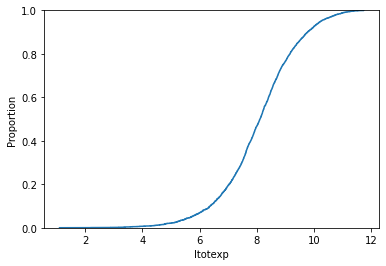

In [3]:
# A plot of the empirical cdf of ltotexp
sns.ecdfplot(data.ltotexp); 

### QR estimates

- The basic QR output for the median regression, with standard errors computed using the default option, is illustrated with the following command.

In [4]:
res = smf.quantreg('ltotexp ~ suppins+totchr+age+female+white', data).fit(q=.5)
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.6480,0.336,16.807,0.000,4.989,6.307
suppins,0.2770,0.053,5.247,0.000,0.173,0.380
totchr,0.3943,0.020,19.769,0.000,0.355,0.433
age,0.0149,0.004,3.639,0.000,0.007,0.023
female,-0.0881,0.052,-1.681,0.093,-0.191,0.015
white,0.4997,0.161,3.110,0.002,0.185,0.815


### Retransformation

- For our example, with the dependent variable `ltotexp` = ln(`totexp`), the results from QR give marginal effects for ln(`totexp`). 
- We may want instead to compute the marginal effects on `totexp`, not `ltotexp`.
- Given $Q_q(\ln y|x) = x'\beta_q$, we have $Q_q(y|x) = \exp{Q_q(\ln y|x)} = exp(x'\beta_q)$.

- The marginal effects on y in levels, given QR model $x'\beta_q$ in logs, is then $$ \frac{\partial Q_q(y|x)}{\partial x_j} = \exp(x'\beta_q)\beta_{qj} $$
- The average marginal effect (AME) is ${N^{-1}\sum^N_{i=1}\exp(x'_i\beta_q)}\beta_{qj}$ and can be estimated if we use the postestimation predict command to obtain $\exp(x'_i\hat{\beta}_q)$ and then average.

In [5]:
xb=res.predict()
ame=np.mean(np.exp(xb))
ame

3746.6722752180335

- For example, the AME of `totchr` on ln(`totexp`) is 0.3943 from the output above. 
- The implied AME of `totchr` on the levels variable is therefore $3746.7 \times 0.3943 = 1477$. 
- One more chronic condition increases the conditional median of expenditures by \$ 1,477.

- The equivariance property that $Q_q(y|x) = \exp{Q_q(\ln y|x)}$ is exact only if the conditional quantile function is correctly specified. 
- This is unlikely to be the case because the linear model will inevitably be only an approximation. 

### Comparison of estimates at different quantiles

- QRs can be performed at different quantiles, specifically the quartiles q = 0.25, 0.50, and 0.75. 
- Here we do so and compare the results with one another and with OLS estimates.
- The QR standard errors use the default formula.

In [6]:
ols = smf.ols('ltotexp ~ suppins+totchr+age+female+white', data).fit()
mod = smf.quantreg('ltotexp ~ suppins+totchr+age+female+white', data)
qr = [mod.fit(q) for q in [0.25,0.5,0.75]]

from statsmodels.iolib.summary2 import summary_col
summary_col(results=[ols,*qr], stars = True, model_names=['OLS', 'QR25', 'QR50', 'QR75'], regressor_order=['suppins','totchr','age','female','white','Intercept'], drop_omitted=True)

,OLS,QR25,QR50,QR75
suppins,0.2568***,0.3856***,0.2770***,0.1489**
,(0.0465),(0.0586),(0.0528),(0.0601)
totchr,0.4453***,0.4590***,0.3943***,0.3735***
,(0.0175),(0.0234),(0.0199),(0.0220)
age,0.0127***,0.0155***,0.0149***,0.0183***
,(0.0036),(0.0046),(0.0041),(0.0046)
female,-0.0765*,-0.0161,-0.0881*,-0.1219**
,(0.0461),(0.0578),(0.0524),(0.0598)
white,0.3178**,0.3376*,0.4997***,0.1932
,(0.1414),(0.1791),(0.1607),(0.1839)


- The coefficients vary across quantiles. 
- Most noticeably, the highly statistically significant regressor `suppins` (supplementary insurance) has a much greater impact at the lower conditional quantiles of expenditure. 
- The standard errors are smaller for median regression (q = 0.50) than for the upper and lower quantiles (q = 0.25, 0.75), reflecting more precision at the center of the distribution. 
- OLS coefficients differ considerably from the QR coefficients, even those for median regression.

###  Heteroskedasticity test

- One reason for coefficients differing across quantiles is the presence of heteroskedastic errors. 
- The OLS standard errors are similar to the default is obtained, suggesting little heteroskedasticity. 
- And the logarithmic transformation of the dependent variable that has been used often reduces heteroskedasticity.

- We use est at hettest to test against heteroskedasticity, which depends on the same variables as those in the regression.

In [7]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

name = ['Lagrange multiplier statistic', 'p-value']
test = sms.het_breuschpagan(res.resid, res.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 74.35281266756185),
 ('p-value', 1.2695769657588735e-14)]

### Graphical display of coefficients over quantiles

- An attractive way to present QR results is via a graphical display of coefficients of interest and their respective confidence intervals.
- This can be done manually by estimating the parameters of the QR model for a range of values of q, saving the results to file, and producing separate graphs for each regressor of the estimated coefficient plotted against the quantile q.

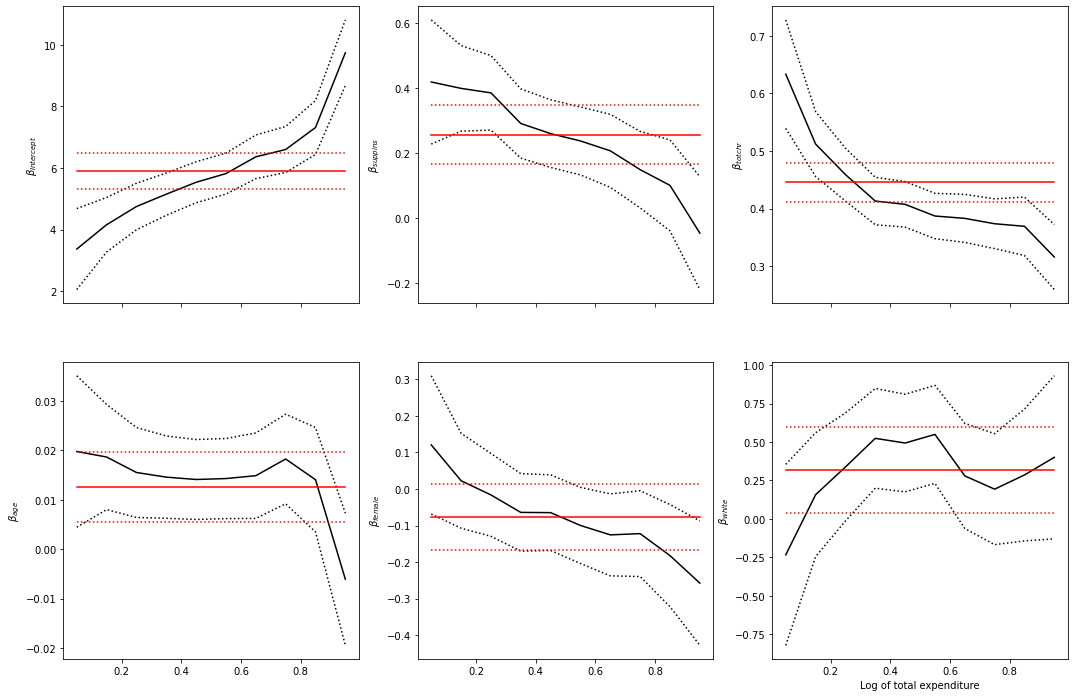

In [8]:
quantiles = np.arange(.05, .96, .1)
mod = smf.quantreg('ltotexp ~ suppins+totchr+age+female+white', data)
ols_mod = smf.ols('ltotexp ~ suppins+totchr+age+female+white', data).fit()
var = ols_mod.params.index
fig, axs = plt.subplots(2, 3, figsize=[18,12], sharex=True)

def fit_model(q,v):
    res = mod.fit(q=q)
    return [q, res.params[v]] + res.conf_int().loc[v].tolist()

for i,v in enumerate(var):
    models = [fit_model(x,v) for x in quantiles]
    models = pd.DataFrame(models, columns=['q', v, 'lb', 'ub'])
    ols_ci = ols_mod.conf_int().loc[v].tolist()
    ols = dict(a=ols_mod.params['Intercept'], b=ols_mod.params[v],lb=ols_ci[0],ub=ols_ci[1])
    n = models.shape[0]
    axs[i//3,i%3].plot(models.q, models[v], color='black', label='Quantile Reg.')
    axs[i//3,i%3].plot(models.q, models.ub, linestyle='dotted', color='black')
    axs[i//3,i%3].plot(models.q, models.lb, linestyle='dotted', color='black')
    axs[i//3,i%3].plot(models.q, [ols['b']] * n, color='red', label='OLS')
    axs[i//3,i%3].plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
    axs[i//3,i%3].plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
    axs[i//3,i%3].set(ylabel=f'$\\beta_{{{v}}}$')
plt.xlabel('Log of total expenditure')
plt.show()

## QR for generated heteroskedastic data

- To gain more insight on QR, we consider a simulation example where the quantiles are known to be linear, and we specify a particular form of multiplicative heteroskedasticity.

### Simulated dataset

- We use a simulated dataset, one where the conditional mean of y depends on the regressors $x_2$ and $x_3$, while the conditional variance depends on only $x_2$.
- The specifi c data-generating process (DGP) is $$ y = 1 + 1\times x_2 + 1\times x_3 + u; \; x_2\sim\chi^2(1), x_3\sim N(0, 25) $$ $$ u = (0.1 + 0.5\times x_2)\times \epsilon; \; \epsilon\sim N(0, 25) $$

- We expect that the QR estimates of the coefficient of $x_3$ will be relatively unchanged at 1 as the quantiles vary, while the QR estimates of the coefficient of $x_2$ will increase as q increases (because the heteroskedasticity is increasing in $x_2$).

In [9]:
np.random.seed(10101)
n=10000
x2=stats.chi2(1).rvs(n)
x3=stats.norm(0,5).rvs(n)
e=stats.norm(0,5).rvs(n)
u=(0.1+0.5*x2)*e
y=1+x2+x3+u
data=pd.DataFrame({'e':e,'x2':x2,'x3':x3,'u':u,'y':y})
data.describe([])

,e,x2,x3,u,y
count,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000
mean,0.009297,1.003198e+00,0.020820,0.019571,2.043589
std,5.001633,1.408229e+00,4.997392,4.588500,6.911582
min,-19.691690,1.219840e-08,-17.588107,-62.326108,-49.990008
50%,0.119003,4.639789e-01,-0.011775,0.028463,1.715701
max,19.264648,1.645352e+01,20.527481,58.301087,58.645511


- Before we analyze the data, we run a quick check to compare the estimated coefficients with their theoretical values. 
- The output below shows that the estimates are roughly in line with the theory underlying the DGP.

In [10]:
mod = smf.quantreg('y ~ x2+x3', data)
qr = [mod.fit(q) for q in [0.25,0.5,0.75]]

from statsmodels.iolib.summary2 import summary_col
summary_col(results=qr, stars = True, model_names=['QR25', 'QR50', 'QR75'])

,QR25,QR50,QR75
Intercept,0.6603***,0.9848***,1.3293***
,(0.0221),(0.0194),(0.0206)
x2,-0.6941***,1.1512***,2.6871***
,(0.0129),(0.0112),(0.0119)
x3,0.9968***,0.9980***,0.9980***
,(0.0035),(0.0032),(0.0034)


In [11]:
[1+0.5*np.quantile(data.e,q) for q in [0.25,0.5,0.75]]

[-0.7022558826514034, 1.0595017353734224, 2.672143867886666]

- We study the distribution of y further by using several plots.

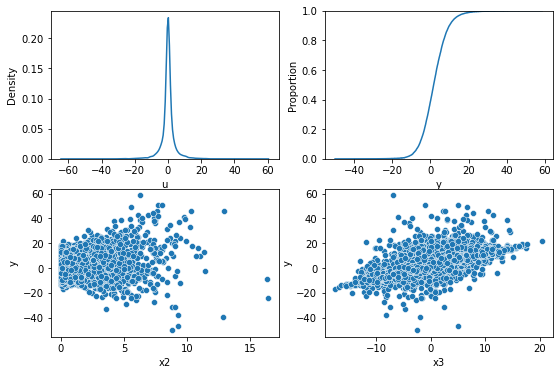

In [12]:
fig, axs = plt.subplots(2, 2, figsize=[9,6])
sns.kdeplot(data.u, ax=axs[0,0])
sns.ecdfplot(data.y, ax=axs[0,1])
sns.scatterplot(data=data, y='y', x='x2', ax=axs[1,0])
sns.scatterplot(data=data, y='y', x='x3', ax=axs[1,1]);

- Here $x_2$ affects both the conditional mean and variance of y, whereas $x_3$ enters only the conditional mean function. 
- The regressor $x_2$ will impact the conditional quantiles differently, whereas $x_3$ will do so in a constant way. 
- The OLS regression can only display the relationship between average y and (x2, x3). 
- QR, however, can show the relationship between the regressors and the distribution of y.

### QR estimates

- We next estimate the regression using OLS (with heteroskedasticity-robust standard errors) and QR at q = 0.25, 0.50, and 0.75.
- The saved results are displayed in a table.

In [13]:
ols_mod = smf.ols('y ~ x2+x3', data)
ols = [ols_mod.fit(),ols_mod.fit(cov_type='HC1')]
mod = smf.quantreg('y ~ x2+x3', data)
qr = [mod.fit(q) for q in [0.25,0.5,0.75]]

summary_col(results=[*ols, *qr], stars = True, model_names=['OLS','OLS_Rob','QR25', 'QR50', 'QR75'], regressor_order=['x2','x3','Intercept'], drop_omitted=True)

,OLS,OLS_Rob,QR25,QR50,QR75
x2,1.0216***,1.0216***,-0.6941***,1.1512***,2.6871***
,(0.0326),(0.1107),(0.0129),(0.0112),(0.0119)
x3,0.9933***,0.9933***,0.9968***,0.9980***,0.9980***
,(0.0092),(0.0091),(0.0035),(0.0032),(0.0034)
Intercept,0.9980***,0.9980***,0.6603***,0.9848***,1.3293***
,(0.0563),(0.0816),(0.0221),(0.0194),(0.0206)
